# 고객 이탈 예측 프로젝트

## 프로젝트 개요

이 프로젝트는 **고객 이탈 예측(Customer Churn Prediction)**을 위한 머신러닝 모델을 구축합니다.

### 목표
- 고객의 이탈 가능성을 예측하여 사전 대응
- 고객 유지 전략 수립을 위한 인사이트 도출

### 데이터셋
- **출처**: Kaggle - Telco Customer Churn
- **다운로드**: https://www.kaggle.com/datasets/blastchar/telco-customer-churn
- **크기**: 약 7,000개 고객 데이터
- **특성**: 고객 정보, 계약 정보, 서비스 사용 정보 등
- **타겟**: Churn (이탈 여부)


## 1. 라이브러리 임포트


In [1]:
# model_training.ipynb
# 셀 1: 라이브러리 임포트
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)
import joblib
import json
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

print("라이브러리 임포트 완료!")


라이브러리 임포트 완료!


## 2. 데이터 로드 및 탐색


In [2]:
# 셀 2: 데이터 로드
# 데이터 파일 경로 설정 (Kaggle에서 다운로드한 파일)
# 파일명: WA_Fn-UseC_-Telco-Customer-Churn.csv

df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

print("데이터 로드 완료!")
print(f"데이터 크기: {df.shape}")
print(f"\n컬럼 목록:")
print(df.columns.tolist())
print(f"\n데이터 미리보기:")
df.head()


데이터 로드 완료!
데이터 크기: (7043, 21)

컬럼 목록:
['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

데이터 미리보기:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
# 셀 3: 데이터 탐색
print("=== 데이터 기본 정보 ===")
print(df.info())

print("\n=== 결측치 확인 ===")
print(df.isnull().sum())

print("\n=== 타겟 변수 분포 ===")
print(df['Churn'].value_counts())
print(f"\n이탈률: {df['Churn'].value_counts(normalize=True)['Yes']:.2%}")


=== 데이터 기본 정보 ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 n

## 3. 데이터 전처리


In [4]:
# 셀 4: 데이터 전처리

# 1. 불필요한 컬럼 제거 (고객 ID)
df_processed = df.drop('customerID', axis=1)

# 2. TotalCharges 컬럼 처리 (공백을 NaN으로 변환 후 처리)
df_processed['TotalCharges'] = pd.to_numeric(df_processed['TotalCharges'], errors='coerce')

# 3. TotalCharges의 결측치를 0으로 채우기 (신규 고객의 경우)
df_processed['TotalCharges'].fillna(0, inplace=True)

# 4. 범주형 변수와 수치형 변수 분리
categorical_cols = df_processed.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df_processed.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Churn을 범주형에서 제외
categorical_cols.remove('Churn')

print(f"범주형 변수: {len(categorical_cols)}개")
print(f"수치형 변수: {len(numerical_cols)}개")
print(f"\n범주형 변수: {categorical_cols}")
print(f"수치형 변수: {numerical_cols}")


범주형 변수: 15개
수치형 변수: 4개

범주형 변수: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
수치형 변수: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']


C:\Users\user\AppData\Local\Temp\ipykernel_20676\1535634080.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_processed['TotalCharges'].fillna(0, inplace=True)


In [5]:
# 셀 5: 범주형 변수 인코딩

# LabelEncoder를 사용하여 범주형 변수 인코딩
label_encoders = {}
df_encoded = df_processed.copy()

for col in categorical_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_processed[col])
    label_encoders[col] = le

# 타겟 변수 인코딩
df_encoded['Churn'] = df_encoded['Churn'].map({'No': 0, 'Yes': 1})

print("인코딩 완료!")
print(f"\n인코딩된 데이터 미리보기:")
df_encoded.head()


인코딩 완료!

인코딩된 데이터 미리보기:


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1


## 4. 데이터 분할


In [6]:
# 셀 6: 독립변수와 종속변수 설정
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

# 데이터 분할 (7:3)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"훈련 데이터: {len(X_train)}개")
print(f"테스트 데이터: {len(X_test)}개")
print(f"\n훈련 데이터 이탈률: {y_train.mean():.2%}")
print(f"테스트 데이터 이탈률: {y_test.mean():.2%}")


훈련 데이터: 4930개
테스트 데이터: 2113개

훈련 데이터 이탈률: 26.53%
테스트 데이터 이탈률: 26.55%


In [7]:
# 셀 7: 수치형 변수 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 스케일링된 데이터를 데이터프레임으로 변환
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print("스케일링 완료!")
print(f"\n스케일링된 데이터 통계:")
print(X_train_scaled.describe())


스케일링 완료!

스케일링된 데이터 통계:
             gender  SeniorCitizen       Partner    Dependents        tenure  \
count  4.930000e+03   4.930000e+03  4.930000e+03  4.930000e+03  4.930000e+03   
mean   8.647579e-18  -6.773937e-17 -5.837116e-17  3.675221e-17  1.167423e-16   
std    1.000101e+00   1.000101e+00  1.000101e+00  1.000101e+00  1.000101e+00   
min   -1.005288e+00  -4.381471e-01 -9.629574e-01 -6.508618e-01 -1.317619e+00   
25%   -1.005288e+00  -4.381471e-01 -9.629574e-01 -6.508618e-01 -9.524160e-01   
50%    9.947400e-01  -4.381471e-01 -9.629574e-01 -6.508618e-01 -1.408545e-01   
75%    9.947400e-01  -4.381471e-01  1.038468e+00  1.536424e+00  9.547535e-01   
max    9.947400e-01   2.282338e+00  1.038468e+00  1.536424e+00  1.604003e+00   

       PhoneService  MultipleLines  InternetService  OnlineSecurity  \
count  4.930000e+03   4.930000e+03     4.930000e+03    4.930000e+03   
mean   5.404737e-17  -3.747284e-17    -7.710758e-17    3.098716e-17   
std    1.000101e+00   1.000101e+00     1.0

## 5. 모델 학습


In [8]:
# 셀 8: 로지스틱 회귀 모델 학습
model_lr = LogisticRegression(max_iter=1000, random_state=42)
model_lr.fit(X_train_scaled, y_train)

print("로지스틱 회귀 모델 학습 완료!")

# 예측 및 평가
y_pred_lr = model_lr.predict(X_test_scaled)
y_pred_proba_lr = model_lr.predict_proba(X_test_scaled)[:, 1]

print(f"\n정확도: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"정밀도: {precision_score(y_test, y_pred_lr):.4f}")
print(f"재현율: {recall_score(y_test, y_pred_lr):.4f}")
print(f"F1 점수: {f1_score(y_test, y_pred_lr):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba_lr):.4f}")


로지스틱 회귀 모델 학습 완료!

정확도: 0.8041
정밀도: 0.6503
재현율: 0.5668
F1 점수: 0.6057
ROC AUC: 0.8429


In [9]:
# 셀 9: 랜덤 포레스트 모델 학습
model_rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
model_rf.fit(X_train_scaled, y_train)

print("랜덤 포레스트 모델 학습 완료!")

# 예측 및 평가
y_pred_rf = model_rf.predict(X_test_scaled)
y_pred_proba_rf = model_rf.predict_proba(X_test_scaled)[:, 1]

print(f"\n정확도: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"정밀도: {precision_score(y_test, y_pred_rf):.4f}")
print(f"재현율: {recall_score(y_test, y_pred_rf):.4f}")
print(f"F1 점수: {f1_score(y_test, y_pred_rf):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba_rf):.4f}")


랜덤 포레스트 모델 학습 완료!

정확도: 0.7941
정밀도: 0.6452
재현율: 0.4991
F1 점수: 0.5628
ROC AUC: 0.8335


## 6. 모델 비교 및 선택


In [10]:
# 셀 10: 모델 성능 비교
models_comparison = pd.DataFrame({
    '모델': ['로지스틱 회귀', '랜덤 포레스트'],
    '정확도': [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_rf)
    ],
    '정밀도': [
        precision_score(y_test, y_pred_lr),
        precision_score(y_test, y_pred_rf)
    ],
    '재현율': [
        recall_score(y_test, y_pred_lr),
        recall_score(y_test, y_pred_rf)
    ],
    'F1 점수': [
        f1_score(y_test, y_pred_lr),
        f1_score(y_test, y_pred_rf)
    ],
    'ROC AUC': [
        roc_auc_score(y_test, y_pred_proba_lr),
        roc_auc_score(y_test, y_pred_proba_rf)
    ]
})

print("=== 모델 성능 비교 ===")
print(models_comparison.round(4))

# 최종 모델 선택 (ROC AUC 기준)
best_model_idx = models_comparison['ROC AUC'].idxmax()
best_model_name = models_comparison.loc[best_model_idx, '모델']

print(f"\n최종 선택 모델: {best_model_name}")

# 최종 모델 저장
if best_model_name == '로지스틱 회귀':
    final_model = model_lr
else:
    final_model = model_rf


=== 모델 성능 비교 ===
        모델     정확도     정밀도     재현율   F1 점수  ROC AUC
0  로지스틱 회귀  0.8041  0.6503  0.5668  0.6057   0.8429
1  랜덤 포레스트  0.7941  0.6452  0.4991  0.5628   0.8335

최종 선택 모델: 로지스틱 회귀


## 7. 시각화


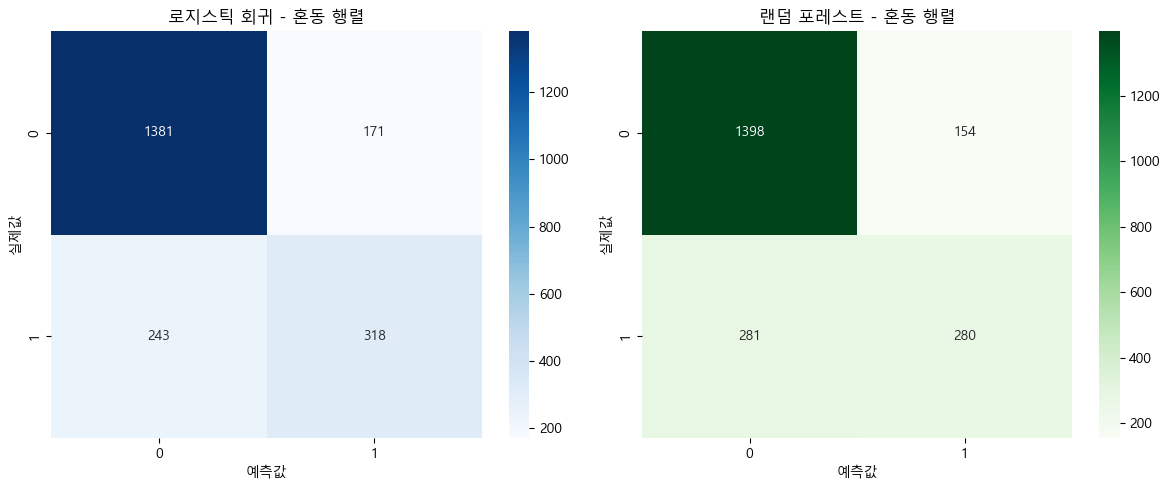

In [11]:
# 셀 11: 혼동 행렬 시각화
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 로지스틱 회귀
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('로지스틱 회귀 - 혼동 행렬')
axes[0].set_xlabel('예측값')
axes[0].set_ylabel('실제값')

# 랜덤 포레스트
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('랜덤 포레스트 - 혼동 행렬')
axes[1].set_xlabel('예측값')
axes[1].set_ylabel('실제값')

plt.tight_layout()
plt.show()


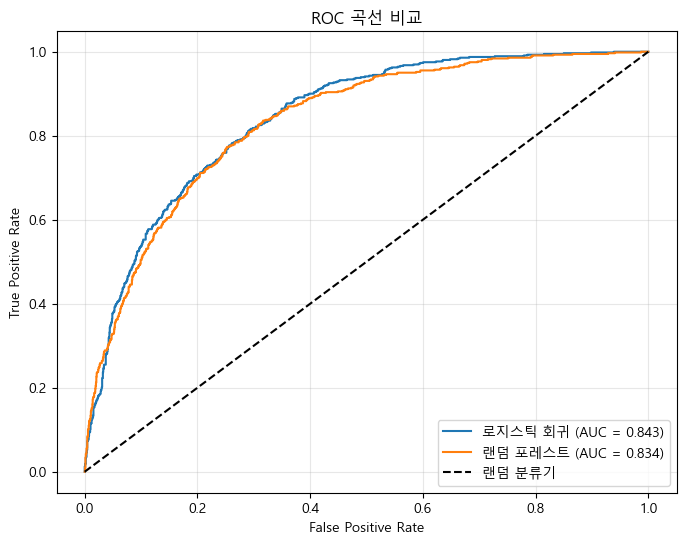

In [12]:
# 셀 12: ROC 곡선 시각화
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f'로지스틱 회귀 (AUC = {roc_auc_score(y_test, y_pred_proba_lr):.3f})')
plt.plot(fpr_rf, tpr_rf, label=f'랜덤 포레스트 (AUC = {roc_auc_score(y_test, y_pred_proba_rf):.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='랜덤 분류기')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC 곡선 비교')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_20676\1258613423.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance.head(15), x='중요도', y='특성', palette='viridis')


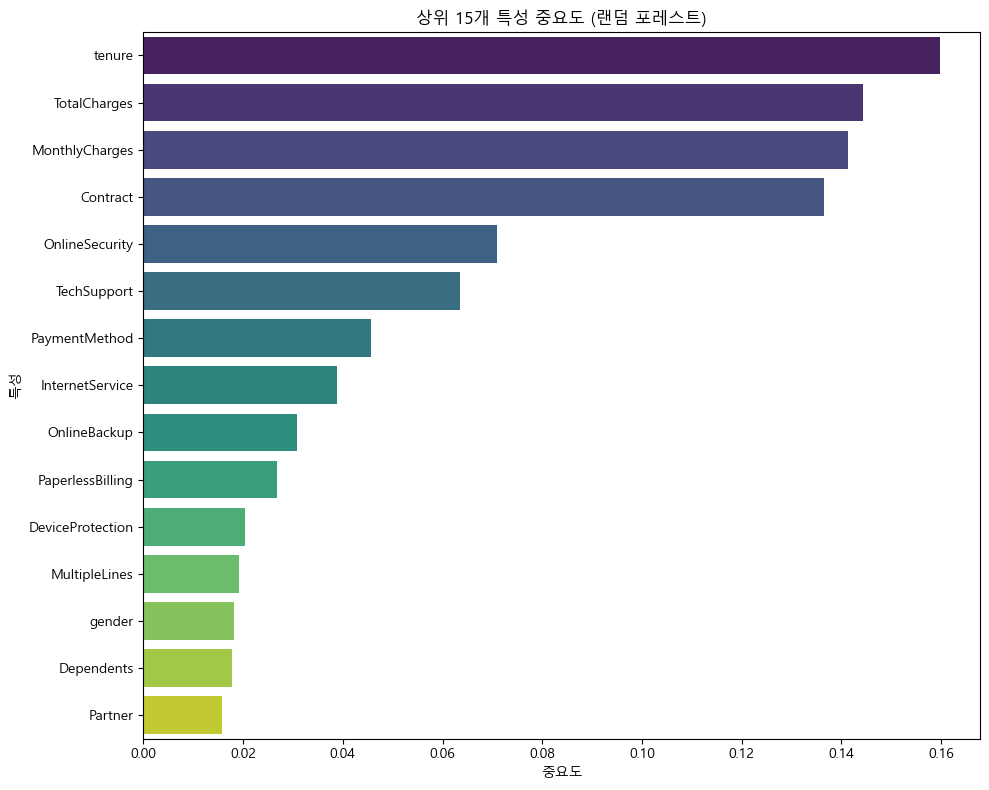


상위 10개 중요 특성:
                  특성       중요도
4             tenure  0.159830
18      TotalCharges  0.144334
17    MonthlyCharges  0.141302
14          Contract  0.136496
8     OnlineSecurity  0.071023
11       TechSupport  0.063502
16     PaymentMethod  0.045608
7    InternetService  0.038811
9       OnlineBackup  0.030839
15  PaperlessBilling  0.026795


In [13]:
# 셀 13: 특성 중요도 시각화 (랜덤 포레스트)
feature_importance = pd.DataFrame({
    '특성': X_train.columns,
    '중요도': model_rf.feature_importances_
}).sort_values('중요도', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance.head(15), x='중요도', y='특성', palette='viridis')
plt.title('상위 15개 특성 중요도 (랜덤 포레스트)')
plt.xlabel('중요도')
plt.tight_layout()
plt.show()

print("\n상위 10개 중요 특성:")
print(feature_importance.head(10))


## 8. 모델 저장


In [14]:
# 셀 14: 최종 모델 저장
joblib.dump(final_model, 'churn_model.joblib')
joblib.dump(scaler, 'scaler.joblib')

# LabelEncoder 저장 (범주형 변수 인코딩용)
joblib.dump(label_encoders, 'label_encoders.joblib')

# 특성 이름 저장
feature_names = X_train.columns.tolist()
with open('feature_names.json', 'w', encoding='utf-8') as f:
    json.dump(feature_names, f, ensure_ascii=False, indent=2)

print("모델 저장 완료!")
print(f"저장된 파일:")
print("- churn_model.joblib")
print("- scaler.joblib")
print("- label_encoders.joblib")
print("- feature_names.json")


모델 저장 완료!
저장된 파일:
- churn_model.joblib
- scaler.joblib
- label_encoders.joblib
- feature_names.json


In [15]:
# 셀 15: 모델 정보 저장
model_info = {
    'model_name': best_model_name,
    'accuracy': float(accuracy_score(y_test, y_pred_rf if best_model_name == '랜덤 포레스트' else y_pred_lr)),
    'precision': float(precision_score(y_test, y_pred_rf if best_model_name == '랜덤 포레스트' else y_pred_lr)),
    'recall': float(recall_score(y_test, y_pred_rf if best_model_name == '랜덤 포레스트' else y_pred_lr)),
    'f1_score': float(f1_score(y_test, y_pred_rf if best_model_name == '랜덤 포레스트' else y_pred_lr)),
    'roc_auc': float(roc_auc_score(y_test, y_pred_proba_rf if best_model_name == '랜덤 포레스트' else y_pred_proba_lr)),
    'feature_names': feature_names,
    'training_samples': len(X_train),
    'test_samples': len(X_test)
}

with open('model_info.json', 'w', encoding='utf-8') as f:
    json.dump(model_info, f, ensure_ascii=False, indent=2)

print("모델 정보 저장 완료!")
print(f"\n모델 정보:")
print(json.dumps(model_info, ensure_ascii=False, indent=2))


모델 정보 저장 완료!

모델 정보:
{
  "model_name": "로지스틱 회귀",
  "accuracy": 0.804070042593469,
  "precision": 0.6503067484662577,
  "recall": 0.5668449197860963,
  "f1_score": 0.6057142857142858,
  "roc_auc": 0.8428874478563684,
  "feature_names": [
    "gender",
    "SeniorCitizen",
    "Partner",
    "Dependents",
    "tenure",
    "PhoneService",
    "MultipleLines",
    "InternetService",
    "OnlineSecurity",
    "OnlineBackup",
    "DeviceProtection",
    "TechSupport",
    "StreamingTV",
    "StreamingMovies",
    "Contract",
    "PaperlessBilling",
    "PaymentMethod",
    "MonthlyCharges",
    "TotalCharges"
  ],
  "training_samples": 4930,
  "test_samples": 2113
}
